In [ ]:
!pip install pandas sentence_transformers nltk numpy gensim scikit-learn transformers

In [43]:
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel
import torch

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [44]:
df = pd.read_csv('/kaggle/input/fake-news-classification/WELFake_Dataset.csv', index_col=0)
df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


<Axes: xlabel='label'>

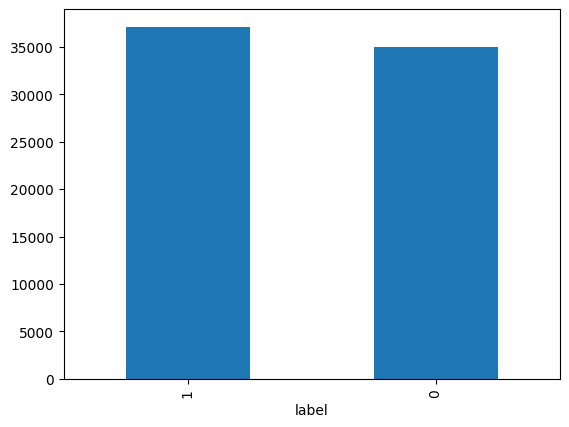

In [45]:
df['label'].value_counts().plot(kind='bar')

In [46]:
sample = df.groupby('label').sample(2000, random_state=42).reset_index()

In [47]:
sample['label'].value_counts()

label
0    2000
1    2000
Name: count, dtype: int64

### The old way of doing it: doc2vec

In [49]:
def doc2vec_tokenize(sequence: str): return word_tokenize(str(sequence).lower())


doc2vec_tokens = sample['text'].apply(doc2vec_tokenize).tolist()

In [50]:
len(doc2vec_tokens)

4000

In [51]:
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(doc2vec_tokens)]


In [52]:
len(tagged_data)

4000

In [53]:
## Train doc2vec model
#window = The maximum distance between the current and predicted word within a sentence.
#min_count = disregard frequent words
model = Doc2Vec(tagged_data, vector_size = 100, window = 5, min_count = 2, epochs = 50)
model.build_vocab(tagged_data)

In [54]:
doc2vec_vectors = model.dv.vectors

In [78]:
 len(doc2vec_vectors)

4000

In [56]:
query = "The 2020 election was stolen and Donald Trump should have won."
test_doc = word_tokenize(query.lower())
test_doc_vector = model.infer_vector(test_doc)
model.docvecs.most_similar(positive = [test_doc_vector])


/tmp/ipykernel_47/1933022414.py:4: DeprecationWarning:

Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).



[(179, 0.3348890244960785),
 (304, 0.3105112612247467),
 (1196, 0.3082645535469055),
 (2878, 0.30020570755004883),
 (3915, 0.29066717624664307),
 (3369, 0.2883043885231018),
 (1943, 0.26843762397766113),
 (2410, 0.2669416069984436),
 (3839, 0.2600543797016144),
 (1361, 0.25713422894477844)]

In [66]:
' '.join(tagged_data[179][0])

'is genetics destiny when it comes to heart disease ? a new analysis of data from more than 55 , 000 people provides an answer . it finds that by living right — by not smoking , by exercising moderately and by eating a healthy diet heavy in fruits , vegetables and grains — people can tamp down even the worst genetic risk . “ dna is not destiny it is not deterministic for this disease , ” said dr. sekar kathiresan , the director of the center for human genetic research at massachusetts general hospital . “ you do have control over the problem , even if you have been dealt a bad genetic hand . ” the research , by dr. kathiresan and his colleagues , is the first attempt to use large data sets to tease apart the effects of genes and lifestyle in heart disease , researchers said . it was published on sunday in the new england journal of medicine to coincide with the presentation of the results at the annual meeting of the american heart association . about 365 , 000 people die of coronary h

### Newer method: sentencebert

In [79]:
sbert = SentenceTransformer('bert-base-nli-mean-tokens')
sbert.to('cuda:0')

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [80]:
sbert_vectors = sbert.encode(sample['text'])

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

In [81]:
sbert_vectors

array([[-0.46520048,  0.67978215, -0.9531239 , ...,  0.11325732,
         0.41025984,  0.16832742],
       [-0.71878505,  0.27849233,  0.58064747, ..., -0.39709905,
        -0.5256523 ,  0.52530783],
       [-0.47340506,  0.5962665 ,  0.04695405, ...,  0.15363792,
         0.44703382, -0.08912414],
       ...,
       [ 0.02432062,  1.139926  , -0.5137914 , ..., -0.43699074,
        -0.06472678,  0.38632807],
       [-0.63683045,  0.6059325 , -0.12349489, ..., -0.429999  ,
         0.07265191,  0.279356  ],
       [-0.4940504 ,  0.9133133 ,  0.48703784, ..., -0.6930462 ,
         0.17556138,  0.30102757]], dtype=float32)

In [82]:
query = 'The 2020 election was stolen and Donald Trump is the winner.'

In [83]:
query_vec = sbert.encode([query])[0].reshape(1, -1)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [86]:
similarities = cosine_similarity(query_vec, sbert_vectors)
similarities

array([[0.4139641 , 0.5619284 , 0.49890316, ..., 0.5671902 , 0.70316935,
        0.5780893 ]], dtype=float32)

In [76]:
top_4 = np.argpartition(similarities, -4, axis=1)[0][-4:].tolist()

In [87]:
for item in sample['text'][top_4]: 
    print('-'*50)
    print(item)

--------------------------------------------------
Wednesday 9 November 2016 by Davywavy Vladimir Putin declares victory in US Presidential elections 
Vladimir Putin has been elected the 45th President of the United Stares after a stunning victory last night. 
Putin, who was a surprise contender when he entered the race last year, consistently outperformed expectations outpolling all challengers and besting his competition in debates. 
Putin has announced that he will run the United States through a proxy as he is much too busy running the far more important country of Russia. 
In a shock victory, American voters showed they were prepared to overlook Putin’s history of running the KGB in favour of his perceived strong leadership and no-nonsense attitude. 
Doubts over his economic record were also waved aside, with uncomfortable facts such as Russian GDP halving in the last three years being dismissed as scaremongering. 
“You fellow Americans,” said Putin in his acceptance speech. 
“I h

### SOTA Approach

In [101]:
token_embeddings.size()

torch.Size([1, 102, 384])

In [121]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = input_mask_expanded.sum(1)
    sum_mask = torch.clamp(sum_mask, min=1e-9)
    pooled = sum_embeddings / sum_mask
    return pooled

In [115]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model.to('cuda:0')

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
    

In [122]:
# Load one by one such that we do not get memory errors
sota_vectors = []
for example in sample['text']:
    encoded_input = tokenizer(str(example), padding=True, truncation=True, return_tensors='pt')
    encoded_input.to('cuda:0')
    with torch.no_grad():
        model_output = model(**encoded_input)
    embedding = mean_pooling(model_output, encoded_input['attention_mask'])
    sota_vectors.append(embedding.detach().cpu().numpy())
    

In [123]:
print(np.array(sota_vectors).shape)
sota_vectors = np.array(sota_vectors).reshape(4000, 384)

(4000, 1, 384)


In [124]:
sota_vectors.shape

(4000, 384)

In [125]:
query_tokens = tokenizer(query,  padding=True, truncation=True, return_tensors='pt')
query_tokens.to('cuda:0')
query_vec = mean_pooling(model(**query_tokens), query_tokens['attention_mask']).detach().cpu().numpy()


In [126]:
top_4

[2224, 2280, 2242, 3681]

In [127]:
similarities = cosine_similarity(query_vec, sota_vectors)


top_4 = np.argpartition(similarities, -4, axis=1)[0][-4:].tolist()

for item in sample['text'][top_4]: 
    print('-'*50)
    print(item)

--------------------------------------------------
Donald Trump won GOP primaries in seven states and Sen. Ted Cruz took three in a Super Tuesday rebound, sparking renewed calls from some Republicans to unify around a single Trump rival as the billionaire tightened his hold on front-runner status.

The contests in 11 states showcased Trump’s dominance over a crowded GOP field. Sen. Marco Rubio (Fla.) was the winner in one state: Minnesota, his first victory of the 2016 primary season.

[Live updates and results from across the U.S.]

Trump won Alabama, Arkansas, Georgia, Massachusetts, Tennessee, Vermont and Virginia, according to Edison Media Research. In several states, his lead was in double digits, and his share of the GOP vote neared 50 percent. With those wins, Trump has more than doubled his victory total in this GOP primary season.

But even as Trump basked in his Super Tuesday romp, a well-funded super PAC was ramping up its effort to discredit the New York businessman with a 

In [128]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

In [129]:
def pca(sentence_embeddings, model):
    pca = PCA(n_components = 2)
    scalar = StandardScaler()
    sentence_embeddings = scalar.fit_transform(sentence_embeddings) #scaling the data
    pca.fit(sentence_embeddings)
    df = pd.DataFrame(pca.components_).T
    df['model'] = model
    print(f'Variance explained: {sum(pca.explained_variance_ratio_)} for {model}')
    return df

In [130]:
!mkdir embeddings
np.save('embeddings/doc2vec', doc2vec_vectors)
np.save('embeddings/sbert', sbert_vectors)
np.save('embeddings/sota', sota_vectors)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


mkdir: cannot create directory ‘embeddings’: File exists


In [131]:
doc2vec_vectors = np.load('embeddings/doc2vec.npy')
sbert_vectors = np.load('embeddings/sbert.npy')
sota_vectors = np.load('embeddings/sota.npy')

In [132]:
doc2vec_pca = pca(doc2vec_vectors, 'doc2vec')
sbert_pca = pca(sbert_vectors, 'sbert')
sota_pca = pca(sota_vectors, 'sota')

Variance explained: 0.09763790667057037 for doc2vec
Variance explained: 0.15210381895303726 for sbert
Variance explained: 0.12494101002812386 for sota


In [133]:
df = pd.concat([doc2vec_pca, sbert_pca, sota_pca])
df

,0,1,model
0,-0.070569,-0.027821,doc2vec
1,0.252953,0.029209,doc2vec
2,-0.061264,0.065124,doc2vec
3,0.079028,-0.066343,doc2vec
4,0.023978,0.079556,doc2vec
...,...,...,...
379,0.042788,0.036420,sota
380,0.126490,0.014467,sota
381,0.112417,-0.023684,sota
382,0.039898,-0.062828,sota


In [134]:
import plotly.express as px

fig = px.scatter(
    df, x=0, y=1,
    color='model', labels={'color': 'label'},
    title = 'Different Sentence Embeddings')
fig.show()


In [135]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


def classify(embeddings, model, classifier):
    x_train, x_test, y_train, y_test = train_test_split(embeddings, sample['label'], test_size=0.25, random_state=0)
    scalar = StandardScaler()   
    x_train, x_test = scalar.fit_transform(x_train), scalar.fit_transform(x_test)
    clf = classifier()
    clf.fit(x_train, y_train)
    score = clf.score(x_test, y_test)
    print(f'Accuracy: {score} for {model}')



In [137]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [138]:
classify(doc2vec_vectors, 'doc2vec', LogisticRegression)

Accuracy: 0.801 for doc2vec


In [139]:
classify(sbert_vectors, 'sbert', LogisticRegression)

Accuracy: 0.89 for sbert


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [140]:
classify(sota_vectors, 'sota', LogisticRegression)

Accuracy: 0.875 for sota


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

